# Func: Read and sparse X-ray/neutron diffraction refinement files produced by Fullprof

In [1]:
##################################################################
# Three functions for import and plot PRF file from fullprof #
##################################################################
# 
from latexify import latexify
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
plt.rcParams["font.family"] = 'arial'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
#plt.rcParams['figure.figsize'] = 5, 10

### defind the prf object
class prf(object):
    def __init__(self, pname, abc, abg, sg, wavelen, nopeaks, the2, yobs, ycal, yo_c, bragg, bpos):
        self.phasename = pname
        self.abc, self.abg, self.sg, self.wavelen, self.nopeaks   =   abc, abg, sg, wavelen, nopeaks
        self.the2, self.yobs, self.ycal, self.yo_c, self.bragg, self.bpos   =   the2, yobs, ycal, yo_c, bragg, bpos

### read function        
def read_prf(file):
    f=open(file, 'r').readlines()
    dataStartAt = 0
    # read the headerlines: sometime the prf file has different 
    # no. of lines of header; And determine No. of peaks
    for row, line in enumerate(f):
        line = line.rstrip('\n').split()
        if row == 0:
            phasename = line[0]
            idx = line.index('CELL:')
            abc, abg = map(float,line[idx+1:idx+4]), map(float,line[idx+4:idx+7])  
            sg = ''.join(line[line.index('SPGR:')+1:]); 
        elif row == 1:
            noposs = int(line[1])
            wavelen = float(line[2])
        elif line[0]=='2Theta':
            dataStartAt = row+1
            print('dataStartAt', dataStartAt,'th line')
        elif row>10 and len(line)== 5:
            nopeaks = row - dataStartAt
            print('no. of peak', nopeaks)
            break
    the2 = np.zeros([noposs,1],dtype=float)
    bragg = np.zeros([nopeaks,1],dtype=float)
    yobs, ycal, yo_c =np.zeros_like(the2), np.zeros_like(the2), np.zeros_like(the2)
    bpos = np.zeros_like(bragg)
    print("Phase Name ", phasename,"\n", "No of data points", noposs, the2.shape,bragg.shape)
    idx= 0
    # read data : 5 columns （2theta,Yobs,Ycal,Yo-Yc,bragg, braggY）
    for line in f[dataStartAt:]:
        line=line.rstrip('\n').split()
        if len(line)>5: # just use try except for fun!!!
            try:
                the2[idx], yobs[idx], ycal[idx], yo_c[idx], _, bragg[idx], bpos[idx] =np.array(list(map(float,line[0:7])))
                idx += 1
            except:
                print('Except:',line[0:7])
        else:
            the2[idx], yobs[idx], ycal[idx], yo_c[idx] = map(float,line[0:4]) 
            idx += 1
                
    return prf(phasename, abc, abg, sg, wavelen, nopeaks,
               the2.ravel(), yobs.ravel(), ycal.ravel(), yo_c.ravel(), bragg.ravel(), bpos.ravel());

def read_prf_newPRFversion(file):
    f=open(file, 'r').readlines()
    dataStartAt = 0
    # read the headerlines: sometime the prf file has different 
    # no. of lines of header; And determine No. of peaks
    for row, line in enumerate(f):
        line = line.rstrip('\n').split()
        if row == 0:
            phasename = line[0]
            idx = line.index('CELL:')
            abc, abg = map(float,line[idx+1:idx+4]), map(float,line[idx+4:idx+7])  
            sg = ''.join(line[line.index('SPGR:')+1:]); 
        elif row == 1:
            nb_of_phases = int(line[0])
            noposs = int(line[1])
            wavelen = float(line[2])
        elif row == 2:
            nopeaks = np.sum(list(map(int, line[0:nb_of_phases])))
        elif line[0]=='2Theta':
            dataStartAt = row+1
            print('dataStartAt', dataStartAt,'th line')
            break
        elif row==50:
            print('Forced to break')
            break
            
    the2 = np.zeros([noposs,1],dtype=float)
    bragg = np.zeros([nopeaks,1],dtype=float)
    yobs, ycal, yo_c, bkg =np.zeros_like(the2), np.zeros_like(the2), np.zeros_like(the2), np.zeros_like(the2)
    bpos = np.zeros_like(bragg)
    print("Phase Name ", phasename,"\n", "No of data points", noposs, the2.shape,bragg.shape)
    idx, idx0 = 0, 0
    # read data : 5 columns （2theta,Yobs,Ycal,Yo-Yc,bragg, braggY）
    for line in f[dataStartAt:]:
        line=line.rstrip('\n').split()
        if len(line)==5:
            the2[idx], yobs[idx], ycal[idx], yo_c[idx], bkg[idx] = np.array(list(map(float,line[0:5])))
            idx += 1
        else:
            bragg[idx0], bpos[idx0] = np.array(list(map(float,line[0:2])))
            idx0 += 1
                
    return prf(phasename, abc, abg, sg, wavelen, nopeaks,
               the2.ravel(), yobs.ravel(), ycal.ravel(), yo_c.ravel(), bragg.ravel(), bpos.ravel());
###### plot function
# def the autocale_y fun for setting xlim then autoscale Ylim (not used)
def autoscale_y(ax,margin=0.1):
    """This function rescales the y-axis based on the data that is visible given the current xlim of the axis.
    ax -- a matplotlib axes object
    margin -- the fraction of the total height of the y-data to pad the upper and lower ylims"""
    import numpy as np
    def get_bottom_top(line):
        xd = line.get_xdata()
        yd = line.get_ydata()
        lo,hi = ax.get_xlim()
        y_displayed = yd[((xd>lo) & (xd<hi))]
        h = np.max(y_displayed) - np.min(y_displayed)
        bot = np.min(y_displayed)-margin*h
        top = np.max(y_displayed)+margin*h
        return bot,top

    lines = ax.get_lines()
    bot,top = np.inf, -np.inf

    for line in lines:
        new_bot, new_top = get_bottom_top(line)
        if new_bot < bot: bot = new_bot
        if new_top > top: top = new_top
        
    ax.set_ylim(bot,top)

def plot_prf(prf,**kwargs):
    #plot_prf(prf, symblesize, linewidth, axefont, scale, shiftDeff, shiftBragg):
    """Reference Values:
    plot_prf(prf,[4.2,86])
    plot_prf(prf, 4, 1, 14, 1.1, 0, 0)
    """ 
    figsize=(5.5,4); xlim=None; ylim=None; yscale=1.05; dyshift=0.1; bshift=0.05; legendcol=1; lw=0.5
    inset=False; infigsize =[0.5, 0.5, 0.2, 0.2]; inxlim =None; inylim=None; # inset figsize [left, bottom, width, height]
    labelfont=14; ticksize=12; infont=12; savepath=None # if not saved here, the fig can be called and saved later
    for kw in kwargs:
        if kw == "figsize": figsize = kwargs[kw]
        elif kw == "xlim": xlim = kwargs[kw]
        elif kw == "ylim": ylim = kwargs[kw]
        elif kw == "yscale": yscale = kwargs[kw]
        elif kw == "dyshift": dyshift = kwargs[kw]
        elif kw == "bshift": bshift = kwargs[kw]
        elif kw == "legendcol": legendcol = kwargs[kw]
        elif kw == "inset": inset = kwargs[kw]
        elif kw == "infigsize": inset=True; infigsize = kwargs[kw]
        elif kw == "inxlim": inset=True; inxlim = kwargs[kw]
        elif kw == "inylim": inset=True; inylim = kwargs[kw]
        elif kw == "labelfont": labelfont = kwargs[kw]
        elif kw == "ticksize": ticksize = kwargs[kw]
        elif kw == "infont": infont = kwargs[kw]
        elif kw == "savepath": savepath = kwargs[kw]
        elif kw == "lw": lw = kwags[kw]
    # transfer data
    ymax = np.max(prf.yobs)*yscale # for scaling the data small than 1
    the2,yobs,ycal,yo_c,bragg,ybragg = prf.the2, prf.yobs/ymax, prf.ycal/ymax, prf.yo_c/ymax+dyshift,\
                                       prf.bragg, prf.bpos/ymax+bshift   
    # main fig plot
    resterized = False
    fig = plt.figure('fig_prf',figsize=figsize)
    ax = fig.add_subplot(111, autoscale_on=True)
    ax.plot(the2, yobs, 'o', mec = 'red', mfc='white', ms='4', label="Yobs",lw=lw, rasterized=resterized)
    ax.plot(the2, ycal, c='black', label="Ycal", lw=lw, rasterized=resterized)
    ax.plot(the2, yo_c, c='blue',label="Yobs-Ycal", lw=lw, rasterized=resterized)  
    print(the2,yo_c)
    ax.plot(bragg, ybragg, '|', ms='6', c='green', lw=lw, label="Bragg Pos.", rasterized=resterized )  
    
    if xlim != None: plt.xlim(xlim)
    if ylim != None: plt.ylim(ylim)
    
    leg = ax.legend(loc='best',numpoints=1,ncol=legendcol,frameon=True,framealpha=1,fontsize=12,fancybox=True,shadow=False)
    leg.get_frame().set_edgecolor('w') 
    ax.set_xlabel(r'2Theta (degree)',size=labelfont)#,labelpad=0)
    ax.set_ylabel('Intensity (a.u.)',size=labelfont)#,labelpad=0)    
    #plt.xlabel(r"2Theta (degree)",size=labelfont)
    #plt.ylabel('Intensity (a.u.)',size=labelfont)
    #ax.yaxis.labelpad = 5 # ylable position
    plt.minorticks_on()
    plt.xticks(color='k', size=ticksize)
    plt.yticks(color='k', size=ticksize)
    
    # Plot zoomed inset
    if inset==True:
        left, bottom, width, height = infigsize
        ax2 = fig.add_axes([left, bottom, width, height],frame_on=True)#, animated=True)
        ax2.autoscale(enable=True, axis='y', tight=None)
        # ax2.autoscale_view(True,True,False) # it refers to all the data ploted (we can just plot part of the data)
        # just plot the needed data to enable autoscale Y
        if inxlim != None:
            mask = (the2 >= inxlim[0]) & (the2 <= inxlim[1])
            ax2.plot(the2[mask], yobs[mask], 'o', mec = 'red', mfc='white', ms='4', label="Yobs", rasterized=resterized)
            ax2.plot(the2[mask], ycal[mask], c='black',label="Ycal", rasterized=True)
        else:
            ax2.plot(the2, yobs, 'o', mec = 'red', mfc='white', ms='4', label="Yobs", rasterized=resterized)
            ax2.plot(the2, ycal, c='black',label="Ycal",  rasterized=True)            
        if inylim != None: plt.ylim(inylim)
        plt.yticks(visible=False)
        #plt.minorticks_on()
    if savepath != None:
        print("Fig saved ", savepath)
        fig.savefig(savepath, bbox_inches="tight", dpi=500)
    #plt.show()
    return fig, ax
######## this part is use zoom fun, not good: cannot choose the size of the zoomed fig 
#(because it depend on zoomed region and zoom scale) 
#     if inset==True:
#         from matplotlib.ticker import MaxNLocator
#         from mpl_toolkits.axes_grid1.inset_locator import mark_inset
#         from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
#         axins = zoomed_inset_axes(ax, 15, loc=10,
#                                   bbox_to_anchor=(0.6, 0.5), bbox_transform=ax.figure.transFigure)
#         axins.plot(the2, yobs, 'o', mec = 'red', mfc='white', ms='4', label="Yobs")
#         axins.plot(the2, ycal, c='black',label="Ycal")      
#         axins.axis([70, 75, 0, 0.015])
#         #axins.invert_yaxis() # get the ticks point out
#         #axins.xaxis.tick_top()
#         plt.xticks(visible=False)
#         plt.yticks(visible=False)
#         mark_inset(ax, axins, loc1=3, loc2=1, fc="none", ec="0.5",zorder = 3)
#         axins.xaxis.set_major_locator(MaxNLocator(nbins=1, prune='lower'))
    

# Plot

## CaV2O4 single crystal

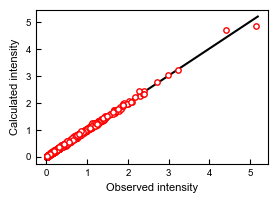

In [38]:
fname = r'D:\2_Neutron_scattering\6_CaV2O4_D3_ILL_2023\0_Data\D9_room_temperature/CaV2O4.prf'
dat = np.genfromtxt(fname,skip_header=2, usecols=[0,1,2])

latexify()
plt.figure(figsize=[3,2])
plt.plot([0,maxI],[0,maxI],c='black',zorder=0)
plt.scatter(dat[:,1]/1e5,dat[:,2]/1e5, marker='o', c='w',s=15, edgecolors='r')
maxI = dat[:,1].max()*1.01/1e5

plt.xlabel('Observed intensity')
plt.ylabel('Calculated intensity')
#plt.savefig(fname.replace('prf','pdf'),bbox_inches="tight", dpi=500)
plt.show()

## Ho2GaSbO7

dataStartAt 4 th line
Phase Name  data_New_Phase_1 
 No of data points 3495 (3495, 1) (174, 1)
[10.1186 10.1386 10.1586 ... 79.9586 79.9786 79.9986] [-0.2410012  -0.24157338 -0.24134361 ... -0.23986134 -0.23956849
 -0.24028034]
Fig saved  D:\4_Physical_Properties\Ho2GaSbO7\XRD\Ho2SbGaO7_1350deg4d_1100deg2d_900deg4d_mix.pdf


Text(35, 0.8, 'Ho$_2$GaSbO$_7$')

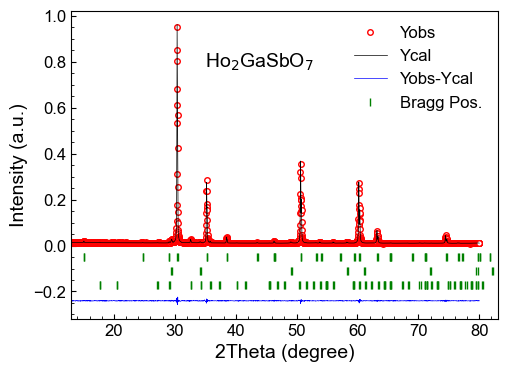

In [2]:
fpath = r"D:\4_Physical_Properties\Ho2GaSbO7\XRD\Ho2SbGaO7_1350deg4d_1100deg2d_900deg4d_mix.prf"
#ho2gasbo7 = read_prf(fpath)
ho2gasbo7 = read_prf_newPRFversion(fpath)

plot_prf(ho2gasbo7,xlim=[13,83],bshift=-0.05,dyshift=0.0,savepath=fpath.replace('prf','pdf'))
ax = plt.gca()
ax.text(35, 0.8,r'Ho$_2$GaSbO$_7$',size=14, ha='left', va='center', 
            backgroundcolor='white',zorder=1,bbox=dict(facecolor='none', edgecolor='white', boxstyle='round'))

dataStartAt 6 th line
Phase Name  Ho2GaSbO7_syncXRD 
 No of data points 71513 (71513, 1) (1021, 1)
[ 0.506  0.507  0.508 ... 72.016 72.017 72.018] [-0.13809552 -0.13809552 -0.13809552 ... -0.13809552 -0.13809552
 -0.13809552]
Fig saved  D:\4_Physical_Properties\Ho2GaSbO7\XRD_sync_ID22_ESRF/Ho2GaSbO7_syncXRD_chevBkg_current.pdf


(<Figure size 550x400 with 2 Axes>,
 <Axes: xlabel='2Theta (degree)', ylabel='Intensity (a.u.)'>)

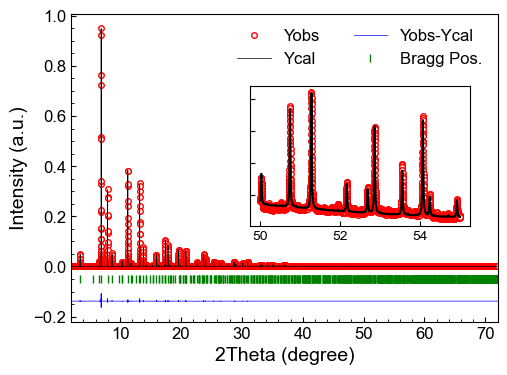

In [3]:
fpath = r"D:\4_Physical_Properties\Ho2GaSbO7\XRD_sync_ID22_ESRF/Ho2GaSbO7_syncXRD_chevBkg_current.prf"
ho2gasbo7 = read_prf_newPRFversion(fpath)

plot_prf(ho2gasbo7,xlim=[2,72],bshift=-0.05,dyshift=0.1,
         inset=True, inxlim=[50,55],infigsize=[0.45,0.35,0.4,0.35],infont=12, 
         legendcol=2,
         savepath=fpath.replace('prf','pdf'))
# ax = plt.gca()
# ax.text(35, 0.8,r'Ho$_2$GaSbO$_7$',size=14, ha='left', va='center', 
#             backgroundcolor='white',zorder=1,bbox=dict(facecolor='none', edgecolor='white', boxstyle='round'))

[13.114 13.133 13.152 ... 82.939 82.958 82.977] [-0.13939448 -0.13894647 -0.13700507 ... -0.13679102 -0.1381948
 -0.13670141]


Text(35, 0.8, 'Sm$_2$Zr$_2$O$_7$')

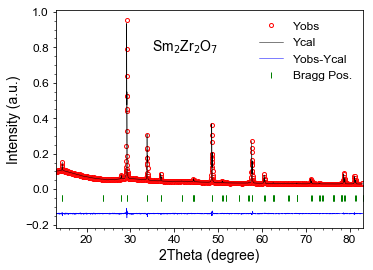

In [34]:
plot_prf(szo,xlim=[13,83],bshift=-0.05,dyshift=0.1)
ax = plt.gca()
ax.text(35, 0.8,r'Sm$_2$Zr$_2$O$_7$',size=14, ha='left', va='center', 
            backgroundcolor='white',zorder=1,bbox=dict(facecolor='none', edgecolor='white', boxstyle='round'))

In [25]:
fpath = r'D:\1_XRD\SmZrO\Isotope/SZO_iso_last.prf'
szo = read_prf(fpath)
#print dir(szo)
print(szo.phasename, szo.sg, szo.abc, szo.abg,szo.nopeaks,szo.wavelen)

plot_prf(szo,xlim=[13,83],bshift=-0.05,dshift=0.01)
ax = plt.gca()
ax.text(32, 0.8,r'$^{154}$Sm$_2$Zr$_2$O$_7$',size=14, ha='left', va='center', 
            backgroundcolor='white',zorder=1,bbox=dict(facecolor='none', edgecolor='white', boxstyle='round'))
ax.yaxis.labelpad = -4 # ylable position
#plt.gcf().savefig(r"D:\1_XRD\SmZrO\Isotope\SZO_iso_last.pdf",bbox_inches="tight",verbose=True)
#plt.gcf().savefig(r"D:\7_Writing\0_my_phd_thesis\Figures\synthesis\SZO_iso_last.pdf",bbox_inches="tight",verbose=True)

dataStartAt 4 th line
no. of peak 70
Phase Name  SZO_isotope 
 No of data points 3678 (3678, 1) (70, 1)
SZO_isotope Fd-3m <map object at 0x000002D955E71A58> <map object at 0x000002D955E717F0> 70 1.54059


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: 'U' mode is deprecated


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[13.114 13.133 13.152 ... 82.939 82.958 82.977] [-0.13658164 -0.13777154 -0.1359645  ... -0.13688012 -0.13684785
 -0.13677928]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: 'U' mode is deprecated


dataStartAt 4 th line
no. of peak 69
Phase Name  GdZrO_crystal_ann 
 No of data points 1464 (1464, 1) (69, 1)
GdZrO_crystal_ann FD-3M <map object at 0x000001E1E8499898> <map object at 0x000001E1E848ADA0> 69 1.54059
[13.294 13.343 13.392 ... 84.883 84.932 84.981] [-0.14003984 -0.13866859 -0.13588601 ... -0.13779453 -0.13820349
 -0.13731339]


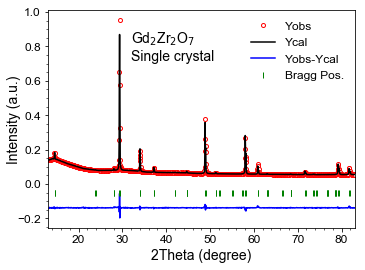

In [5]:
# Ｓｉｎｇｌｅ　ｃｒｙｓｔａｌ　Ｇｄ２Ｚｒ２Ｏ７
fpath = r'D:\1_XRD\GdZrO\Sigl Cry/Gd2Zr2O7_sgl_crys_more_ann_15_14_13_151014.prf'
xrd = read_prf(fpath)
#print dir(szo)
print(xrd.phasename, xrd.sg, xrd.abc, xrd.abg, xrd.nopeaks, xrd.wavelen)

plot_prf(xrd,xlim=[13,83],bshift=-0.05,dyshift=0.1)
ax = plt.gca()
ax.text(32, 0.8,r'Gd$_2$Zr$_2$O$_7$'+'\n'+'Single crystal',size=14, ha='left', va='center', 
            backgroundcolor='white',zorder=1,bbox=dict(facecolor='none', edgecolor='white', boxstyle='round'))
ax.yaxis.labelpad = -4 # ylable position
#plt.gcf().savefig(r'D:\1_XRD\GdZrO\Sigl Cry/Gd2Zr2O7_sgl_crys_more_ann_15_14_13_151014.pdf',bbox_inches="tight",verbose=True)
#plt.gcf().savefig(r'D:\7_Writing\0_my_phd_thesis\Figures\synthesis\Gd2Zr2O7_sgl_crys_more_ann_15_14_13_151014.pdf',bbox_inches="tight",verbose=True)

dataStartAt 4 th line
no. of peak 226
Phase Name  Sm2Zr2O7_long_cry_MoreAnn_MuchPowder_020115 
No of data points 4837 (4837L, 1L) (226L, 1L)
Sm2Zr2O7_long_cry_MoreAnn_MuchPowder_020115 Fd-3m [10.59857, 10.59857, 10.59857] [90.0, 90.0, 90.0] 226 1.54059


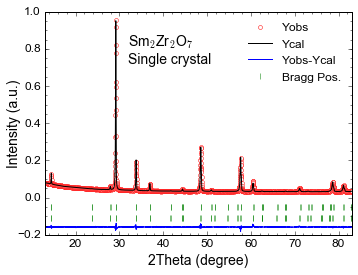

In [24]:
# Ｓｉｎｇｌｅ　ｃｒｙｓｔａｌ　Ｓｍ２Ｚｒ２Ｏ７
fpath = r'D:\1_XRD\SmZrO\Sm2Zr2O7_long_cry_MoreAnn_MuchPowder_020115.prf'
xrd = read_prf(fpath)
#print dir(szo)
print xrd.phasename, xrd.sg, xrd.abc, xrd.abg, xrd.nopeaks, xrd.wavelen

plot_prf(xrd,xlim=[13,83],bshift=-0.05,dyshift=0.08)
ax = plt.gca()
ax.text(32, 0.8,r'Sm$_2$Zr$_2$O$_7$'+'\n'+'Single crystal',size=14, ha='left', va='center', 
            backgroundcolor='white',zorder=1,bbox=dict(facecolor='none', edgecolor='white', boxstyle='round'))
ax.yaxis.labelpad = -4 # ylable position
#plt.gcf().savefig(r'D:\1_XRD\SmZrO\Sm2Zr2O7_long_cry_MoreAnn_MuchPowder_020115.pdf',bbox_inches="tight",verbose=True)
#plt.gcf().savefig(r'D:\7_Writing\0_my_phd_thesis\Figures\synthesis\Sm2Zr2O7_long_cry_MoreAnn_MuchPowder_020115.pdf',bbox_inches="tight",verbose=True)


dataStartAt 4 th line
no. of peak 112
Phase Name  Nd2Zr2O7_crstal_X22_ann 
No of data points 4837 (4837L, 1L) (112L, 1L)
Nd2Zr2O7_crstal_X22_ann Fd-3m [10.65062, 10.65062, 10.65062] [90.0, 90.0, 90.0] 112 1.54059


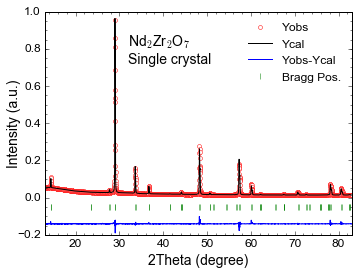

In [25]:
# Ｓｉｎｇｌｅ　ｃｒｙｓｔａｌ　Ｎｄ２Ｚｒ２Ｏ７
fpath = r'D:\1_XRD\NdZrO\Nd2Zr2O7_crstal_X22_ann.prf'
xrd = read_prf(fpath)
print xrd.phasename, xrd.sg, xrd.abc, xrd.abg, xrd.nopeaks, xrd.wavelen

plot_prf(xrd,xlim=[13,83],bshift=-0.05,dyshift=0.1)
ax = plt.gca()
ax.text(32, 0.8,r'Nd$_2$Zr$_2$O$_7$'+'\n'+'Single crystal',size=14, ha='left', va='center', 
            backgroundcolor='white',zorder=1,bbox=dict(facecolor='none', edgecolor='white', boxstyle='round'))
ax.yaxis.labelpad = -4 # ylable position
#plt.gcf().savefig(r'D:\1_XRD\NdZrO\Nd2Zr2O7_crstal_X22_ann.pdf',bbox_inches="tight",verbose=True)
#plt.gcf().savefig(r'D:\7_Writing\0_my_phd_thesis\Figures\synthesis\Nd2Zr2O7_crstal_X22_ann.pdf',bbox_inches="tight",verbose=True)


dataStartAt 4 th line
no. of peak 72
Phase Name  Nd2Sn2O7 
No of data points 4205 (4205L, 1L) (72L, 1L)
Nd2Sn2O7 Fd-3m [10.56845, 10.56845, 10.56845] [90.0, 90.0, 90.0] 72 1.54056


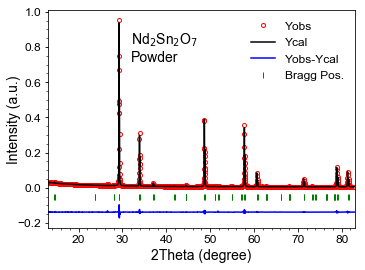

In [8]:
# Ｓｉｎｇｌｅ　ｃｒｙｓｔａｌ　Ｎｄ２Ｚｒ２Ｏ７
fpath = r'D:\1_XRD\NdSnO\Nd2Sn2O7_1000_1200_1300_1400_onePhase.prf'
xrd = read_prf(fpath)
print xrd.phasename, xrd.sg, xrd.abc, xrd.abg, xrd.nopeaks, xrd.wavelen

plot_prf(xrd,xlim=[13,83],bshift=-0.05,dyshift=0.1)
ax = plt.gca()
ax.text(32, 0.8,r'Nd$_2$Sn$_2$O$_7$'+'\n'+'Powder',size=14, ha='left', va='center', 
            backgroundcolor='white',zorder=1,bbox=dict(facecolor='none', edgecolor='white', boxstyle='round'))
ax.yaxis.labelpad = -4 # ylable position
plt.gcf().savefig(r'D:\1_XRD\NdSnO\Nd2Sn2O7_1000_1200_1300_1400_onePhase.pdf',bbox_inches="tight",verbose=True)


In [43]:
# Ｃｏｍｂｉｎｄｅｄ　ｒｅｆｉｎｅｍｅｎｔ
# Ｎｅｕｔｒｏｎ　ａｎｄ　ＸＲＤ　ｏｆ　ｉｓｏｔｏｐｅ　１６０Ｇｄ２Ｚｒ２Ｏ７
fpath =[ r'D:\isotope-gdzro_ND_XRD_combined_refine\Gd2zr2o7_ND_XRD_1.prf',
         r'D:\isotope-gdzro_ND_XRD_combined_refine\Gd2zr2o7_ND_XRD_2.prf']
diffdat= read_prf(fpath[0])
print(diffdat.phasename, diffdat.sg, diffdat.abc, diffdat.abg, diffdat.nopeaks,diffdat.wavelen)

plot_prf(diffdat,figsize=(5.5,4), xlim=[10,157],ylim=[-0.1,1], yscale=1.05, dyshift=0.18, bshift=0.02, legendcol=1)

ax = plt.gca()
ax.text(40, 0.8,r'$^{160}$Gd$_2$Zr$_2$O$_7$'+'\n'+'Neutron',size=14, ha='left', va='center', 
            backgroundcolor='white',zorder=1,bbox=dict(facecolor='none', edgecolor='white', boxstyle='round'))
#ax.yaxis.labelpad = -4 # ylable position

#plt.gcf().savefig(r'D:\isotope-gdzro_ND_XRD_combined_refine\Gd2zr2o7_ND_XRD_1.pdf',bbox_inches="tight",verbose=True)
#plt.gcf().savefig(r'D:\7_Writing\0_my_phd_thesis\Figures\synthesis\Gd2zr2o7_ND_XRD_1.pdf',bbox_inches="tight",verbose=True)
plt.show()

# Plot with inset
#plot_prf(diffdat,figsize=(5.5,4), xlim=[10,157],ylim=[-0.1,1], yscale=1.05, dyshift=0.18, bshift=0.02, legendcol=2,\
         #inset=True,infigsize=[0.45,0.35,0.4,0.35], inxlim=[115,125],infont=12)#,\
        #avepath=r"D:\5_Neutron Scattering\3 D20_ILL_Dec2014\GdZrO_D2B_HighRes_NeutronDiffraction\Gd2zr2o7_rt_hr_105A.pdf")
    

diffdat= read_prf(fpath[1])
print(diffdat.phasename, diffdat.sg, diffdat.abc, diffdat.abg, diffdat.nopeaks,diffdat.wavelen)

plot_prf(diffdat,figsize=(5.5,4), xlim=[12,103],ylim=[-0.1,1], yscale=1.05, dyshift=0.18, bshift=0.0, legendcol=1)
ax = plt.gca()
ax.text(32, 0.8,r'$^{160}$Gd$_2$Zr$_2$O$_7$'+'\n'+'X ray',size=14, ha='left', va='center', 
            backgroundcolor='white',zorder=1,bbox=dict(facecolor='none', edgecolor='white', boxstyle='round'))
#plt.gcf().savefig(r'D:\isotope-gdzro_ND_XRD_combined_refine\Gd2zr2o7_ND_XRD_2.pdf',bbox_inches="tight",verbose=True)
#plt.gcf().savefig(r'D:\7_Writing\0_my_phd_thesis\Figures\synthesis\Gd2zr2o7_ND_XRD_2.pdf',bbox_inches="tight",verbose=True)

<ipython-input-4-1087613104ca>:24: DeprecationWarning: 'U' mode is deprecated
  f=open(file, 'rU').readlines()


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\isotope-gdzro_ND_XRD_combined_refine\\Gd2zr2o7_ND_XRD_1.prf'

## Gd2Hf2O7

dataStartAt 7 th line
no. of peak 74
Phase Name  Gd2Hf2O7 
 No of data points 3196 (3196, 1) (74, 1)
Gd2Hf2O7 FD-3MTEMP:0.00 <map object at 0x0000027A0039CAF0> <map object at 0x0000027A0039CCD0> 74 1.594
[  0.2    0.25   0.3  ... 159.85 159.9  159.95] [-0.06103228 -0.06103228 -0.06103228 ... -0.06103228 -0.06103228
 -0.06103228]


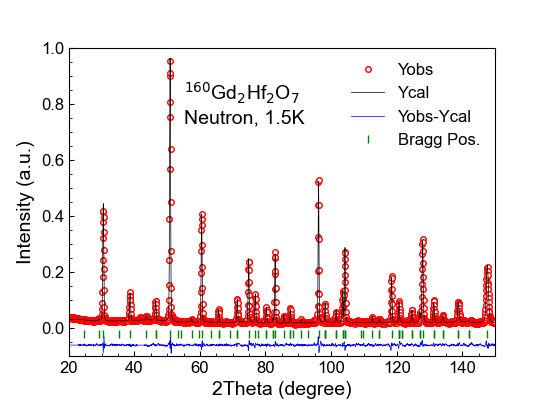

In [5]:
fpath = [r'D:\Gd2Hf2O7_combined_refine_4highTs/1p1_hr_diff_fraenkel_exclureg_no_gd_hf_disorder_o2full_Baniso_bkg_1.prf',
         r'D:\Gd2Hf2O7_combined_refine_7Ts/Exclude_linearBkg3lowT_noMix_no_Frank_bkg_ins_prof_x_11Frank_OBaniso_asym_not11Frank_GdHfBaniso_11mix_O8a_1.prf',
         r'D:\2_Neutron_scattering\1_D2B_Gd2Hf2O7\Combined\Gd2Hf2O7_combined_refine_7Ts_difference_linearBKG3lowT\1p1_hr_diff_fraenkel_exclureg_no_gd_hf_disorder_o2full_Baniso_bkg_ins_occOconstr_prof_xO_Baniso_exclu4143_asym_11mixing_O8a_1.prf']
file = fpath[2]
diffdat= read_prf(file)
print(diffdat.phasename, diffdat.sg, diffdat.abc, diffdat.abg, diffdat.nopeaks,diffdat.wavelen)

fig, ax = plot_prf(diffdat,figsize=(5.5,4), xlim=[20,150],ylim=[-0.1,1], yscale=1.05, dyshift=0.18, bshift=-0.02, legendcol=1)
ax.text(55, 0.8,r'$^{160}$Gd$_2$Hf$_2$O$_7$'+'\n'+'Neutron, 1.5K',size=14, ha='left', va='center', 
            backgroundcolor='white',zorder=1,bbox=dict(facecolor='none', edgecolor='white', boxstyle='round'))
#ax.yaxis.labelpad = -4 # ylable position

fig.savefig(file.replace('prf','pdf'),bbox_inches="tight", pad_inches=0.01)
plt.show()


# Plot synchron data

In [7]:
# Nd2Zr2O7 Fullprof
fpath1 = 'D:/1_XRD/1 MSbeamline_July2014/Nd2Zr2O7/NZO5K.prf'
nzo = read_prf(fpath1)
print(nzo.phasename,nzo.abc, nzo.abg, nzo.sg, nzo.nopeaks,nzo.wavelen)#,nzo.the2

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: 'U' mode is deprecated


dataStartAt 5 th line
no. of peak 756
Phase Name  NZO5K 
 No of data points 23787 (23787, 1) (756, 1)
NZO5K <map object at 0x000001E1E85743C8> <map object at 0x000001E1E8574160> Fd-3m 756 0.49573


[ 0.3708  0.3744  0.378  ... 85.9932 85.9968 86.0004] [-0.14760802 -0.14760802 -0.14760802 ... -0.14727606 -0.14721085
 -0.14741833]


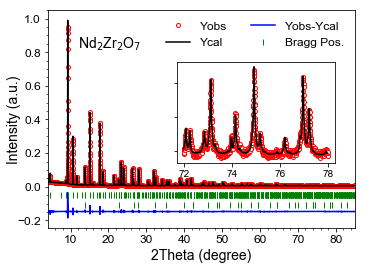

In [8]:
# % matplotlib notebook
plot_prf(nzo,xlim=[4,85],bshift=-0.05,dshift=0.0,
         inset=True,infigsize=[0.45,0.35,0.4,0.35],inxlim=[72,78], infont=12, legendcol=2)
ax = plt.gcf().get_axes()[0]
ax.text(12, 0.85,r'Nd$_2$Zr$_2$O$_7$',size=14, ha='left', va='center', 
            backgroundcolor='white',zorder=1,bbox=dict(facecolor='none', edgecolor='white', boxstyle='round'))
ax.yaxis.labelpad = -4 # ylable position

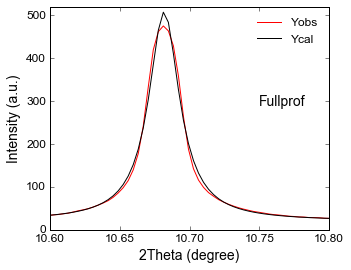

In [11]:
# plot one peak
# main fig plot

fig = plt.figure('peak',figsize=[5,4])
ax = fig.add_subplot(111, autoscale_on=True)
ax.plot(nzo.the2, nzo.yobs, '-', c = 'red',  label="Yobs")
ax.plot(nzo.the2, nzo.ycal, c='black',label="Ycal")

plt.xlim([15.05,15.2])
plt.ylim([0,800])


plt.xlim([23.3,23.5])
plt.ylim([0,300])

plt.xlim([10.6,10.8])
plt.ylim([0,520])

ax.text(10.75,300,'Fullprof',size=14, ha='left', va='center',
        backgroundcolor='white',picker=True,bbox=dict(facecolor='white', alpha=0, edgecolor='white', boxstyle='round'))

leg = ax.legend(loc='best',numpoints=1,ncol=1,frameon=True,framealpha=1,fontsize=12,fancybox=True,shadow=False)
leg.get_frame().set_edgecolor('w') 
ax.set_xlabel(r'2Theta (degree)',size=14)#,labelpad=0)
ax.set_ylabel('Intensity (a.u.)',size=14)#,labelpad=0)    

#ax.yaxis.labelpad = 5 # ylable position
#plt.minorticks_on()
plt.xticks(color='k', size=12)
plt.yticks(color='k', size=12)
#plt.gcf().savefig(r'D:/1_XRD/1 MSbeamline_July2014/Nd2Zr2O7/nd_xrd_peak_fullprof.pdf',bbox_inches="tight",verbose=True)
plt.show()

In [12]:
################ Plot Topase data ###############
# Ｏｌｄ　Nd2Zr2O7 load and plot the Topas fitted data
fpath1='D:/1_XRD/Try_Topas/NZO/Nd2Zr2O7.txt' # patterns: 2theta, obs, error, cal, differ
fpath2='D:/1_XRD/Try_Topas/NZO/Nd2Zr2O7phase.txt' # bragg pos for phase 1
fpath2='D:/1_XRD/Try_Topas/NZO/Nd2Zr2O7_one.txt' # bragg pos for phase 2
pattern = np.genfromtxt(fpath1, dtype=None, skip_header=2,delimiter=',')
bragg1 = np.genfromtxt(fpath2, dtype=None, skip_header=1,usecols=(6))
bragg2 = np.genfromtxt(fpath2, dtype=None, skip_header=1,usecols=(6))

In [13]:
# make a prf object
nzo1=prf
imax = np.max(pattern[:,1])
nzo1.the2, nzo1.yobs, nzo1.ycal, nzo1.yo_c = \
    pattern[:,0], pattern[:,1], pattern[:,3], pattern[:,4]-imax*0.25 # shift the diff lower than 0
    
bpos1 = -np.ones_like(bragg1)*imax/500. # prepare Bragg positions for one phase
bpos2 = -np.ones_like(bragg2)*imax/40.  # prepare Bragg positions for one phase

nzo1.bragg = bragg1.ravel() 
nzo1.bpos = bpos1.ravel()

#nzo1.bragg = np.vstack((bragg1,bragg2)).ravel() 
#nzo1.bpos = np.vstack((bpos1,bpos2)).ravel()

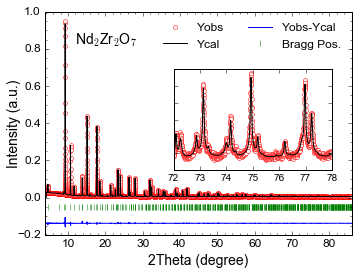

In [14]:
# Plot
#% matplotlib qt
plot_prf(nzo1,figsize=(5.5,4),xlim=[3.8,86],ylim=[-0.2,1.001], yscale=1.05, dyshift=0.1, bshift=-0.05, 
         inset=True,infigsize=[0.45,0.35,0.4,0.35], inxlim=[72,78], infont=12, legendcol=2)
# plot_prf(nzo1,figsize=(5.5,4),xlim=[4,86],ylim=[-0.2,1], yscale=1.05, dyshift=0.1, bshift=-0.05, 
#          inset=True,infigsize=[0.45,0.35,0.4,0.35], inxlim=[72,78], infont=12, legendcol=2,
#          savepath="D:/1_XRD/Try_Topas/NZO/1nzo_topas.pdf")

ax = plt.gcf().get_axes()[0]
ax.text(12, 0.85,r'Nd$_2$Zr$_2$O$_7$',size=14, ha='left', va='center', 
            backgroundcolor='white',zorder=1,bbox=dict(facecolor='none', edgecolor='white', boxstyle='round'))
ax.yaxis.labelpad = -4 # ylable position

plt.gcf().savefig(r'D:/1_XRD/Try_Topas/NZO/nd_pow_xrd.pdf',bbox_inches="tight",verbose=True)

In [15]:
# Plot a peak for comparing Topas and Fullprof
# use new Nd2Zr2O7 Topas data and the above Fullprof data
# below is the two phases data

fpath=r'D:\1_XRD\Try_Topas\0_Topas_export_data_FY\NZO' # patterns: 2theta, obs, error, cal, differ
fnames = ['Nd2Zr2O7_Dia_T5_167_m_WAXS.xye', 'nd_mix_diffB_obs_cal_diff.txt',
          'nd_mix_diffB_phase1.txt', 'nd_mix_diffB_phase2.txt', 'nd_mix_diffB_backg.txt']
temp = np.genfromtxt(os.path.join(fpath, fnames[0]), dtype=None,usecols=(0,1)) # 2th, obs, error
obs = temp[(4.2<temp[:,0]) & (temp[:,0]< 86.1),:]
cal = np.genfromtxt(os.path.join(fpath, fnames[1]), dtype=None, usecols=(1))
phase1 = np.genfromtxt(os.path.join(fpath, fnames[2]), dtype=None, usecols=(1))# obs, cal, diff
phase2 = np.genfromtxt(os.path.join(fpath, fnames[3]), dtype=None, usecols=(1))# obs, cal, diff
backg = np.genfromtxt(os.path.join(fpath, fnames[4]), dtype=None, usecols=(1)) # obs, cal, diff
# make a prf object
print obs.shape, cal.shape, phase1.shape, phase2.shape, backg.shape

(22723L, 2L) (22723L,) (22723L,) (22723L,) (22723L,)


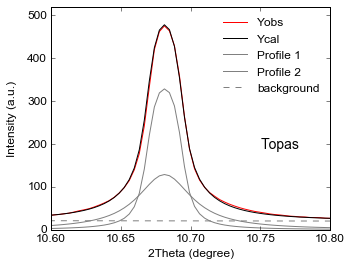

In [17]:
% matplotlib inline

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, autoscale_on=True)
ax.plot(obs[:,0], obs[:,1],'-', c = 'red', label="Yobs")
ax.plot(obs[:,0], cal[:], c='black',label="Ycal")
ax.plot(obs[:,0], phase1[:],'-', c='grey',label="Profile 1")    
ax.plot(obs[:,0], phase2[:], '-', c='grey',label="Profile 2")  
ax.plot(obs[:,0], backg[:], '--', c='grey',label="background") 

plt.xlim([23.3,23.5])
plt.ylim([0,300])

plt.xlim([10.6,10.8])
plt.ylim([0,520])

ax.text(10.75,200,'Topas',size=14, ha='left', va='center',
        backgroundcolor='white',picker=True,bbox=dict(facecolor='white', alpha=0, edgecolor='white', boxstyle='round'))

leg = ax.legend(loc='best',numpoints=1,ncol=1,frameon=True,framealpha=1,fontsize=12,fancybox=True,shadow=False)
leg.get_frame().set_edgecolor('w') 
ax.set_xlabel(r'2Theta (degree)',size=12)#,labelpad=0)
ax.set_ylabel('Intensity (a.u.)',size=12)#,labelpad=0)    
ax.yaxis.labelpad = 10 # ylable position

#plt.minorticks_on()
plt.xticks(color='k', size=12)
plt.yticks(color='k', size=12)
#plt.gcf().savefig(r'D:/1_XRD/1 MSbeamline_July2014/Nd2Zr2O7/nd_xrd_peak_topas.pdf',bbox_inches="tight",verbose=True)

plt.show()

In [18]:
################ Plot Topase data ###############
# La2Zr2O7 load and plot the Topas fitted data
fpath=r'D:\1_XRD\Try_Topas\0_Topas_export_data_FY\LZO' # patterns: 2theta, obs, error, cal, differ
fnames = ['La2Zr2O7_Dia_T5_5_m_WAXS.xye',    'lzo_obs_cal_diff.txt',
          'lzo_strFac.txt', 'lzo_strFac_diamond.txt',   'lzo_backg.txt']
temp = np.genfromtxt(os.path.join(fpath, fnames[0]), dtype=None,usecols=(0,1))
obs = temp[(4.2<temp[:,0]) & (temp[:,0]< 86.1),:]
caldiff = np.genfromtxt(os.path.join(fpath, fnames[1]), dtype=None, usecols=(1,2))# cal, diff
bragg1 = np.genfromtxt(os.path.join(fpath, fnames[2]), dtype=None, usecols=(4,5))# 2th, I
bragg2 = np.genfromtxt(os.path.join(fpath, fnames[3]), dtype=None, usecols=(4,5)) # 2th, I

# make a prf object
xrd = prf
imax = np.max(obs[:,1])
xrd.the2, xrd.yobs, xrd.ycal, xrd.yo_c = \
    obs[:,0], obs[:,1], caldiff[:,0], caldiff[:,1]-imax*0.25 # shift the diff lower than 0
    
bpos1 = -np.ones_like(bragg1)*imax/500. # prepare Bragg positions for one phase
bpos2 = -np.ones_like(bragg2)*imax/40.  # prepare Bragg positions for one phase

xrd.bragg = bragg1.ravel() 
xrd.bpos = bpos1.ravel()

In [11]:
print obs.shape, caldiff.shape

(22722L, 2L) (22723L, 2L)


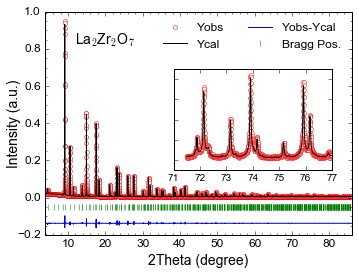

In [20]:
# Plot
% matplotlib inline
plot_prf(xrd,figsize=(5.5,4),xlim=[3.8,86],ylim=[-0.2,1.001], yscale=1.05, dyshift=0.1, bshift=-0.05,legendcol=2,
         inset=True,infigsize=[0.45,0.35,0.4,0.35], inxlim=[71.5,77],inylim=[0.003,0.013], infont=12)
# plot_prf(nzo1,figsize=(5.5,4),xlim=[4,86],ylim=[-0.2,1], yscale=1.05, dyshift=0.1, bshift=-0.05, 
#          inset=True,infigsize=[0.45,0.35,0.4,0.35], inxlim=[72,78], infont=12, legendcol=2,
#          savepath="D:/1_XRD/Try_Topas/NZO/1nzo_topas.pdf")

ax = plt.gcf().get_axes()[0]
ax.text(12, 0.85,r'La$_2$Zr$_2$O$_7$',size=14, ha='left', va='center', 
            backgroundcolor='white',zorder=1,bbox=dict(facecolor='none', edgecolor='white', boxstyle='round'))
ax.yaxis.labelpad = -4 # ylable position

plt.gcf().savefig(os.path.join(fpath, 'la_pow_xrd.pdf'),bbox_inches="tight",verbose=True)

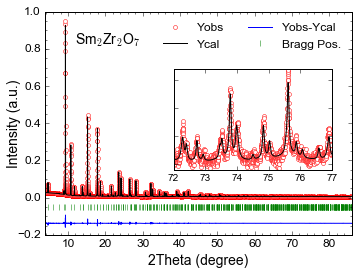

In [21]:
################ Plot Topase data ###############
# Sm2Zr2O7 load and plot the Topas fitted data
fpath=r'D:\1_XRD\Try_Topas\0_Topas_export_data_FY\SZO' # patterns: 2theta, obs, error, cal, differ
fnames = ['Sm2Zr2O7_Dia_T5_corrected_WAXS.xye',    'sm_obs_cal_diff.txt',
          'sm_strFac.txt', 'sm_strFac_diamond.txt',   'sm_backg.txt']
temp = np.genfromtxt(os.path.join(fpath, fnames[0]), dtype=None,usecols=(0,1))
obs = temp[(4.2<temp[:,0]) & (temp[:,0]< 86.1),:]
caldiff = np.genfromtxt(os.path.join(fpath, fnames[1]), dtype=None, usecols=(1,2))# cal, diff
bragg1 = np.genfromtxt(os.path.join(fpath, fnames[2]), dtype=None, usecols=(4,5))# 2th, I
bragg2 = np.genfromtxt(os.path.join(fpath, fnames[3]), dtype=None, usecols=(4,5)) # 2th, I

# make a prf object
xrd = prf
imax = np.max(obs[:,1])
xrd.the2, xrd.yobs, xrd.ycal, xrd.yo_c = \
    obs[:,0], obs[:,1], caldiff[:,0], caldiff[:,1]-imax*0.25 # shift the diff lower than 0
    
bpos1 = -np.ones_like(bragg1)*imax/500. # prepare Bragg positions for one phase
bpos2 = -np.ones_like(bragg2)*imax/40.  # prepare Bragg positions for one phase

xrd.bragg = bragg1.ravel() 
xrd.bpos = bpos1.ravel()

# Plot
% matplotlib inline
plot_prf(xrd,figsize=(5.5,4),xlim=[3.8,86],ylim=[-0.2,1.001], yscale=1.05, dyshift=0.1, bshift=-0.05,legendcol=2,
         inset=True,infigsize=[0.45,0.35,0.4,0.35], inxlim=[72,77], infont=12)
# plot_prf(nzo1,figsize=(5.5,4),xlim=[4,86],ylim=[-0.2,1], yscale=1.05, dyshift=0.1, bshift=-0.05, 
#          inset=True,infigsize=[0.45,0.35,0.4,0.35], inxlim=[72,78], infont=12, legendcol=2,
#          savepath="D:/1_XRD/Try_Topas/NZO/1nzo_topas.pdf")

ax = plt.gcf().get_axes()[0]
ax.text(12, 0.85,r'Sm$_2$Zr$_2$O$_7$',size=14, ha='left', va='center', 
            backgroundcolor='white',zorder=1,bbox=dict(facecolor='none', edgecolor='white', boxstyle='round'))
ax.yaxis.labelpad = -4 # ylable position

#plt.gcf().savefig(os.path.join(fpath, 'sm_pow_xrd.pdf'),bbox_inches="tight",verbose=True)

In [22]:
################ Plot Topase data ###############
# Gd2Zr2O7 load and plot the Topas fitted data
fpath=r'D:\1_XRD\Try_Topas\0_Topas_export_data_FY\GZO' # patterns: 2theta, obs, error, cal, differ
fnames = ['Gd2Zr2O7_Dia_T5_61_m_WAXS.xye',    'gd_obs_cal_diff.txt',
          'gd_strFac.txt', 'gd_strFac_diamond.txt',   'gd_backg.txt']
temp = np.genfromtxt(os.path.join(fpath, fnames[0]), dtype=None,usecols=(0,1))
obs = temp[(4.2<temp[:,0]) & (temp[:,0]< 86.1),:]
caldiff = np.genfromtxt(os.path.join(fpath, fnames[1]), dtype=None, usecols=(1,2))# cal, diff
bragg1 = np.genfromtxt(os.path.join(fpath, fnames[2]), dtype=None, usecols=(4,5))# 2th, I
bragg2 = np.genfromtxt(os.path.join(fpath, fnames[3]), dtype=None, usecols=(4,5)) # 2th, I

# make a prf object
xrd = prf
imax = np.max(obs[:,1])
xrd.the2, xrd.yobs, xrd.ycal, xrd.yo_c = \
    obs[:,0], obs[:,1], caldiff[:,0], caldiff[:,1]-imax*0.25 # shift the diff lower than 0
    
bpos1 = -np.ones_like(bragg1)*imax/500. # prepare Bragg positions for one phase
bpos2 = -np.ones_like(bragg2)*imax/40.  # prepare Bragg positions for one phase

xrd.bragg = bragg1.ravel() 
xrd.bpos = bpos1.ravel()

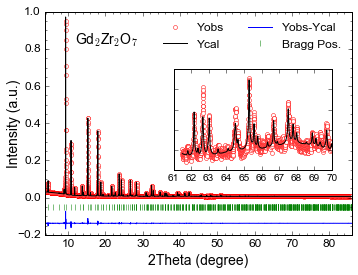

In [23]:
# Plot
% matplotlib inline
plot_prf(xrd,figsize=(5.5,4),xlim=[3.8,86],ylim=[-0.2,1.001], yscale=1.05, dyshift=0.1, bshift=-0.05,legendcol=2,
         inset=True,infigsize=[0.45,0.35,0.4,0.35], inxlim=[61.5,70], infont=12)
# plot_prf(nzo1,figsize=(5.5,4),xlim=[4,86],ylim=[-0.2,1], yscale=1.05, dyshift=0.1, bshift=-0.05, 
#          inset=True,infigsize=[0.45,0.35,0.4,0.35], inxlim=[72,78], infont=12, legendcol=2,
#          savepath="D:/1_XRD/Try_Topas/NZO/1nzo_topas.pdf")

ax = plt.gcf().get_axes()[0]
ax.text(12, 0.85,r'Gd$_2$Zr$_2$O$_7$',size=14, ha='left', va='center', 
            backgroundcolor='white',zorder=1,bbox=dict(facecolor='none', edgecolor='white', boxstyle='round'))
ax.yaxis.labelpad = -4 # ylable position

#plt.gcf().savefig(os.path.join(fpath, 'gd_pow_xrd.pdf'),bbox_inches="tight",verbose=True)

<IPython.core.display.Javascript object>


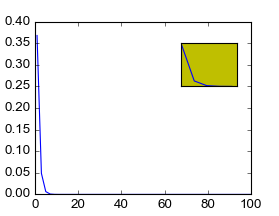

In [34]:
# Test: plot inset
import os
d1 = np.linspace(1,100)
d2 = np.exp(-np.linspace(1,100))
data = np.vstack((d1,d2)).transpose()
#print data
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(data[:,0],data[:,1])

ax2 = plt.axes([.65, .6, .2, .2], axisbg='y') #(left, bottom,width, height)
ax2.plot(data[3:8,0],data[3:8,1])
plt.setp(ax2, xticks=[], yticks=[]) # Good function!!!!

plt.show()

# Func: load DMC data

In [14]:
################################### Read the dmc data ################
########### define the function to read ND DMC data file and the binning fun. #########
#################################################################
#%matplotlib qt
import os
import numpy as np
import matplotlib.pyplot as plt # after importting matplotlib, mayavi can not set api to 2: first run mayavi!!!!

def read_dmc(fpath):
    with open(fpath, 'rU') as f:
        i, ii = 0, 0
        for line in f:     
            if i==0 or i==1:
                line = line.rstrip('\n').split()
                print "The data is",'\n',line
                i+=1
            elif i==2:          ##### Gernerate 2theta from inf. in the 3rd line
                line = line.rstrip('\n').split()
                spts,step,fpts = map(np.float,[line[0],line[1],line[2]])
                numpts = int((fpts-spts)/step+1) # why 1314 is 1313 for np
                print 'The 2theta is',spts,step,fpts,numpts
                diffdata = np.zeros((numpts,3))
                print 'The data shape is',diffdata.shape
                diffdata[:,0] = np.linspace(spts,fpts,num=numpts,endpoint=True)
                i+=1
            else:              ##### Now read the intensity and error
                if ii<numpts:
                    line = line.rstrip('\n').split()
                    apd = len(line)
                    try:
                        diffdata[ii:ii+apd,1]= map(np.float,line)
                        ii+=apd
                    except:
                        print 'Error',ii, line
                        break
                else:
                    if ii<2*numpts:
                        line = line.rstrip('\n').split()
                        apd = len(line)
                        diffdata[ii-numpts:ii-numpts+apd,2]= map(np.float,line)
                        ii+=apd
    return diffdata

#This binning with the error calculated in this way is not good if the input data has too few point. 
# For example, if nbins=size(x), error will be 0.
def lin_binning(x,y,nbins): #input: data x,y ; No of points you want nbins  
    #nbins+=1     
    x = x[~np.isnan(x)] # remove nan from the data
    y = y[~np.isnan(y)]
    
    n, _ = np.histogram(x, bins=nbins) # n=len(x)/nbins
    n[np.argwhere(n==0)]=1 #repalce 0 by 1 for dividing later
    meanx= np.histogram(x, bins=nbins, weights=x)[0] / n
    meany= np.histogram(x, bins=nbins, weights=y) [0]/ n
    meany2= np.histogram(x, bins=nbins, weights=y*y)[0] / n
    std_y = np.sqrt(meany2 - meany*meany)/np.sqrt(n)
    
    return meanx,meany,std_y #putput: nbins rows, 3 col

path='D:/5_Neutron Scattering/2_DMC_PSI_Sep2014__NdGdZrO/xu(data_PSI_Computer)/Gd2Zr2O7/'
fname = os.path.join(path,'Gd_2k_1.dat')
path='D:/5_Neutron Scattering/2_DMC_PSI_Sep2014__NdGdZrO/xu(data_PSI_Computer)/Nd2Zr2O7/'
fname = os.path.join(path,'2.45_100mk.dat')
data1=read_dmc(fname)
print data1,fname.replace('.dat','_colm.dat')
np.savetxt(fname.replace('.dat','_colm.dat'),data1)

The data is 
['DMC,', 'Nd2Zr2O7', '2.45A', '100mK']
The data is 
['lambda=', '2.46087,', 'T=', '0.076,', 'dT=', '0.009,', "Date='2014-09-10", "05:49:42'"]
The 2theta is 11.0 0.1 92.7 818
The data shape is (818L, 3L)
[[    11.   10024.     271.5]
 [    11.1   9921.     270.1]
 [    11.2   9866.     193.9]
 ..., 
 [    92.5   8998.     194.8]
 [    92.6   8849.     270.6]
 [    92.7   9345.     278.1]] D:/5_Neutron Scattering/2_DMC_PSI_Sep2014__NdGdZrO/xu(data_PSI_Computer)/Nd2Zr2O7/2.45_100mk_colm.dat


(2L, 3L)


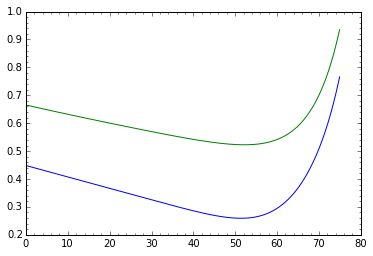

In [15]:
# plot the FWHM function for Fullprof and Topas
% matplotlib inline
def fwhm(uvw, th):
    width = uvw[0]*np.tan(th/180.*np.pi)**2+uvw[1]*np.tan(th/180.*np.pi)+uvw[2]
    return width**0.5
uvw = np.array([[0.085371, -0.213767, 0.201037],
                [0.102, -0.26290, 0.44253]])
print uvw.shape
th = np.linspace(0.0,150.,num=1500, endpoint=False)/2
width = fwhm(uvw[0,:],th)
width1 = fwhm(uvw[1,:],th)
plt.plot(th, width, th, width1)
plt.minorticks_on()
plt.show()

In [14]:
# cal the chemical valence from the fitting result
# first Topas
r, t, o48f, o8a,o8b = 0.7, 0.78, 1, 0.9414, 0.1
cation = (r*3+(1-r)*4)*16 + (t*4+(1-t)*3)*16
anion = o48f*2*48 + o8a*2*8 + o8b*2*8
print cation/8, anion/8
# Second Fullprof
a1, a2, a3 = 0.08333, 0.25, 0.04167
r, t, o48f, o8a,o8b = 0.07869/a1, 0.07567/a1, 0.25/a2, 0.04167/a3, 0/a3
cation = (r*3+(1-r)*4)*16 + (t*4+(1-t)*3)*16
anion = o48f*2*48 + o8a*2*8 + o8b*2*8
print cation/8, anion/8

14.16 14.0828
13.9275171007 14.0


In [21]:
fpath='D:/4_muonSR/mmcalc-1.1beta/output/test1.dat'
data = np.genfromtxt(fpath, dtype=None, skip_header=1,delimiter=" ")
print data
print data[:,1]

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[2 5 8]


In [ ]:
####  Test read function
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
class getCol:
    matrix =[]
    def __init__(self, file, skiplines, delim):
        #with open(file, 'rU').read() as f:  
        f=open(file, 'rU').readlines()[skiplines:]    
        getCol.matrix =[filter(None, line.rstrip('\n').split(delim)) for line in f]

    def __getitem__ (self, key):
        column = []
        for row in getCol.matrix:
            try:
                column.append(row[key])
            except IndexError:
                # pass
                column.append("")
        return column

#f = open(fname,'r')
#lines = f.readlines()[1:]
#f.close()
fpath='D:/4_muonSR/mmcalc-1.1beta/output/test1.dat'
test = getCol(fpath,1,' ')
print test[2]
print getCol(fpath,1,' ')[2]
print getCol(fpath,1,' ').matrix
print map(float, getCol(fpath,1,' ')[2])
numdat=[[float(y) for y in x] for x in getCol(fpath,1,' ').matrix]
print numdat[1]


In [72]:
#with open(fpath, 'r').read().split() as f:
    #mat=[filter(None, line.split(' ')) for line in f]
    #open('test_newlines.txt').read().split()
#mat=open(fpath, 'r').read().split()
with open(file, 'rU') as f:
    for line in f:
        line=line.rstrip('\n')
            
            getCol.matrix =  [filter(None, line.split(delim)) for line in f]
#matrix =  [filter(None, line.split(delim)) for line in f]
print mat

['1', '2', '3', '4', '5', '6', '7', '8', '9']


In [77]:
fpath='D:\Profile\Download\mmcalc-1.1beta\output/test.txt'
print getCol(fpath,' ')[2]

['3\n', '6']


In [51]:

fpath='D:\Profile\Download\mmcalc-1.1beta\output\test.txt'
f = open(r'D:\Profile\Download\mmcalc-1.1beta\output\test1.txt','r')
lines = f.readlines()[1:]
#lines = f.readlines()[2:]
#lines = f.readlines()[3:]
f.close()
print lines

open('dwn.txt', 'rb').readlines()[6:]


['4 5 6\n', '7 8 9']


# Plot XYN file Gd2Hf2O7

In [3]:
xyn = np.genfromtxt(r'D:\2_Neutron_scattering\1_D2B_Gd2Hf2O7\0_data_with_straight_cone/Gd2Hf2O7_1p5-300K_159A_hr_straight.xyn',skip_header=2)
bkg = np.genfromtxt(r'D:\2_Neutron_scattering\1_D2B_Gd2Hf2O7\0_data_with_straight_cone_subtracting_50K_bkg/Extracted_empty_can_bkg(50Kdata-50Kdiff).dat',skip_header=3)

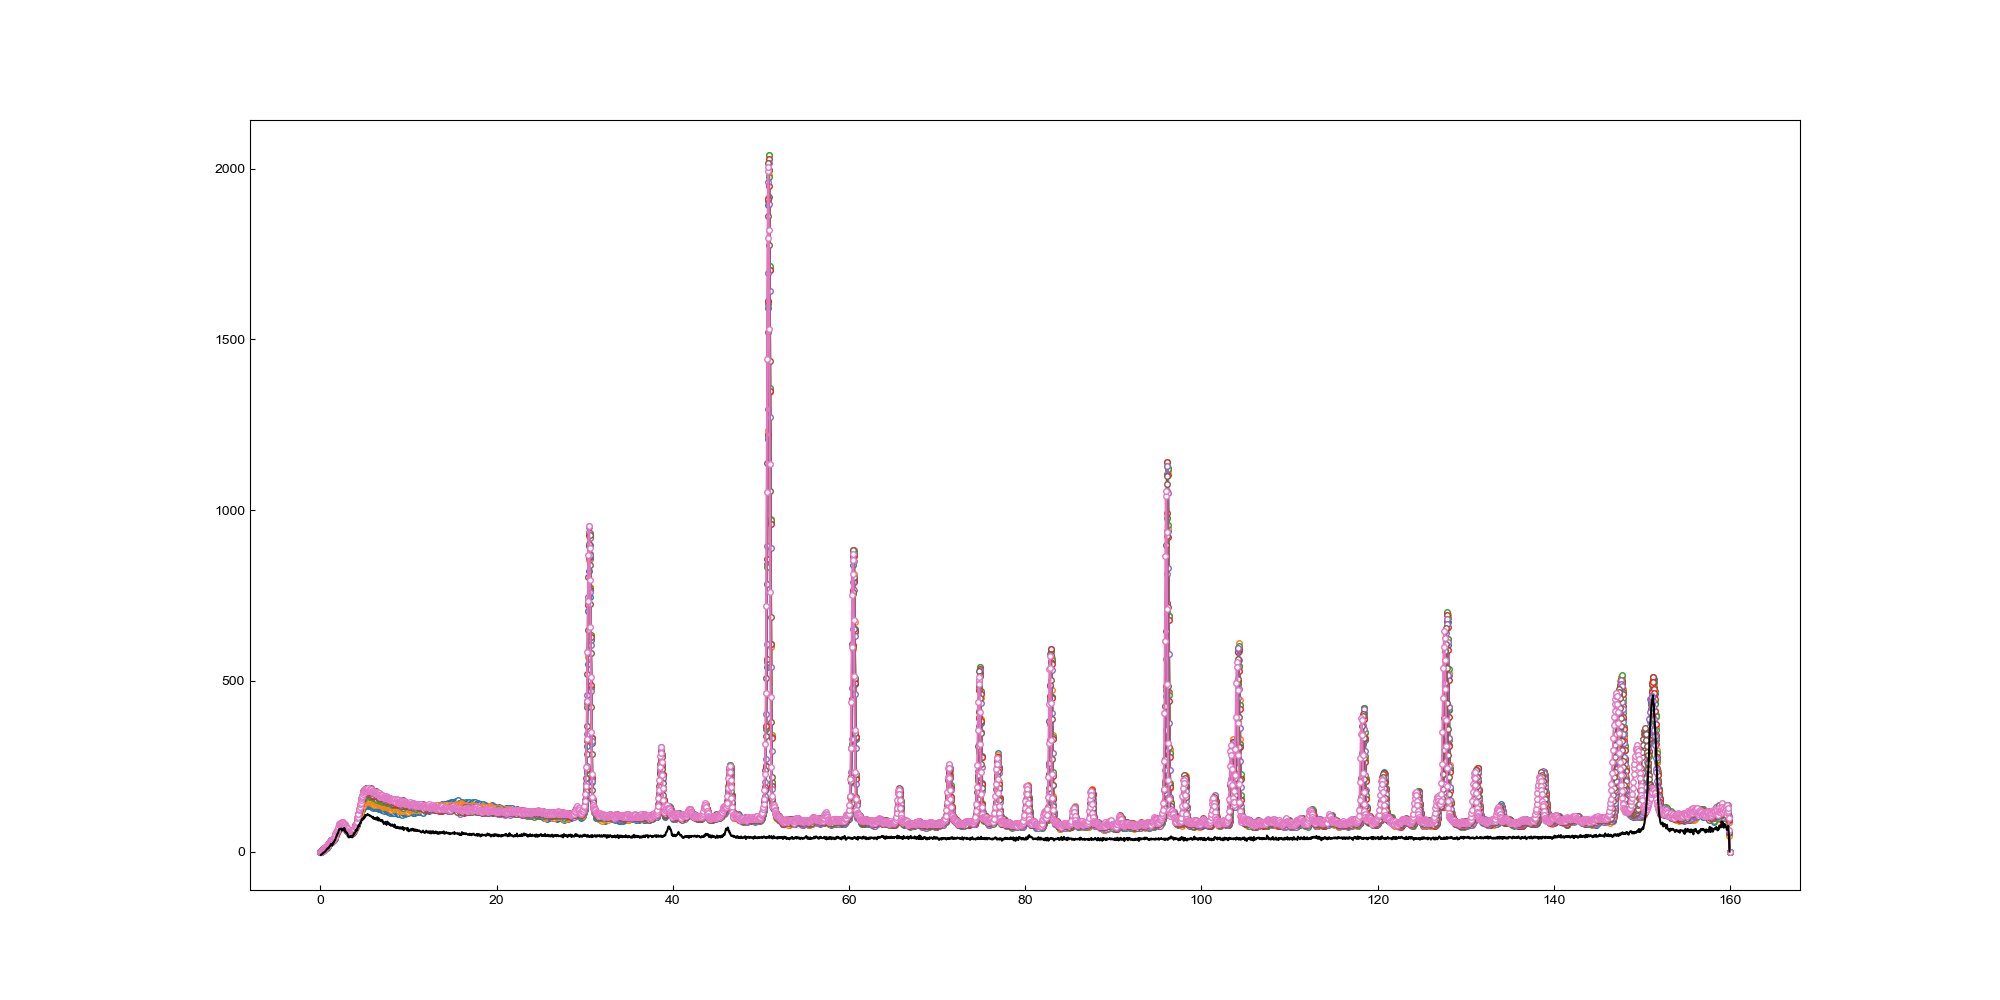

In [4]:
%matplotlib ipympl
%matplotlib ipympl
plt.figure(figsize=(20,10))
for i in np.arange(0,7):
    plt.plot(xyn[:,i*2],xyn[:,i*2+1], '-o', mfc='white', ms='4')
plt.plot(bkg[:,0],bkg[:,1], c='black')
plt.show()

# Other

In [47]:
import numpy as np
fpath1='D:/4_muonSR/mmcalc-1.1beta/output/test2.txt'

line1s=np.zeros([2,3])
sites=np.zeros([1,3])
print line1s, sites

with open(fpath1, 'rU') as f:
    i=0;ii=0
    for line in f:
        line=line.rstrip('\n').split()# without giving delimenter, it will treat conseutive space as one
        #print line
        if line[0]=="line1":
            line1s[i,:]=line[1:]#automatically convert string to np.array
            i=i+1
            print(line[1])
            print(line1s[0,int(line[1])])
        elif line[0]=="site":
            sites[ii,:]=line[1:]
            ii=ii+1
print(line1s)           
print(sites)           

[[ 0.  0.  0.]
 [ 0.  0.  0.]] [[ 0.  0.  0.]]
1
2.0
2
3.0
[[ 1.  2.  3.]
 [ 2.  5.  6.]]
[[ 7.  8.  9.]]


In [125]:
a = np.arange(9).reshape([3,3]) 
print a

np.ravel(a)
print a.ravel()

[[0 1 2]
 [3 4 5]
 [6 7 8]]
[0 1 2 3 4 5 6 7 8]


In [ ]:
(0.0035/2/3.14**2*10.64**2)**0.5
(0.95 / 3.1415**2 / 8)**0.5

# Sparse refine.sum file from Fullprof

In [8]:
def parseLineToDict(line, seplist, startflag = None):
    """ Parse a line with key word and value and to a dictionary. 
    Argument
      - line        :   str
      - seplist     :   list of string
      - startflag   :   str.  If not none, the line must start with this
    Return  :   list
    """
    # 1. Remove start-flag
    if startflag is not None:
        pline = line.split(startflag)[1]
    else:
        pline = line

    # 2. Separate line with all separation flag
    terms = [pline]
    for sepflag in seplist:
        newterms = []
        for origterm in terms:
            septerms = origterm.split(sepflag)
            newterms.extend(septerms)
        terms = newterms
    # LOOP-OVER

    # 3. Conver to key and value
    valuelist = []
    for i in range( 1, len(terms) ):
        newval = parseValue( terms[i], ["(", ")"] )
        valuelist.append( newval )

    return valuelist

class RietException(Exception):
    """
    RietException is the virtual base class for all exceptions raised from pyfullprof.core
    Attributes:
    - message:  error message provided from code
    - errortyp: reason for error (standarized)
    """
    def __init__(self, message, errortype, errorId = ""):
        """
        initialization of RietException's derived class;
        but raising an excpetion if any attempt to raise this virtual base class
        message:   string to describe the reason of this exception
        errortype: standard reason for errortype
        errorId: used to identify specific errors, especially when the errors
            are processed in other packages
        """
        if self.__class__.__name__ == "RietException":
            raise NotImplementedError
        else:
            self.message   = message
            self.errortype = errortype
            self.errorId = ""
       
        return


    def __str__(self):
        """
        print out the message and reason of Exception
        """
        rstring  = ""
        rstring += "\nError Type:  %-20s  Message:  %-30s"% (self.errortype, self.message)
        return rstring
class RietError(RietException):
    """
    rietError is all the standard error usually indicating 
    that there must be something wrong in the python scripts
    Attributes:
    - message:  error message provided from code
    - errortyp: reason for error (standarized)
    """
    def __init__(self, message, errortype="Standard Error", errorId = ""):
        """
        initialization
        """
        RietException.__init__(self, message, errortype, errorId)
        
        return

#!/usr/bin/env python
##############################################################################
#
# diffpy.pyfullprof by DANSE Diffraction group
#                   Simon J. L. Billinge
#                   (c) 2010 Trustees of the Columbia University
#                   in the City of New York.  All rights reserved.
#
# File coded by:    Wenduo Zhou
#
# See AUTHORS.txt for a list of people who contributed.
# See LICENSE.txt for license information.
#
##############################################################################

""" Parser for Fullprof .sum file
"""

#__id__ = "$Id: fpsumparser.py 6843 2013-01-09 22:14:20Z juhas $"

#from diffpy.pyfullprof.stringop import parseLineToDict
#from diffpy.pyfullprof.exception import RietPCRError



class FPSumFileParser:
    """ Class to parse Fullprof .sum file
    """

    def __init__(self, sumfilename):
        """ Initialization of a .sum file
        Argument:
          - sumfilename :   str, .sum file name
        
        Return  :   None
        """
        self.importSumFile(sumfilename)

        return


    def importSumFile(self, sumfilename):
        """ Import a .sum file
        Arguement:
          - sumfilename :   string, summary file name
        Return          :   None
        """
        # 1. Import plain text file
        try:
            sfile = open(sumfilename, "r")
            rawlines = sfile.readlines()
            sfile.close()
        except IOError:
            errmsg = "Fullprof .sum %-15s cannot be read properly\n" % \
                    sumfilename + str(err)
            raise IOError

        # 2. Clean line
        self.lines = []
        for rline in rawlines:
            cline = rline.strip()
            if cline != "":
                self.lines.append(cline)
        # LOOP-OVER

        # 3.  Start to scan the file in order to make some search quicker
        # 3.1 Reliability factor flag position
        self._reliabilityFactorPos = {}
        lineindex = 0
        for line in self.lines:
            terms = line.split("RELIABILITY FACTORS WITH ALL NON-EXCLUDED POINTS FOR PATTERN:")
            if len(terms) > 1:
                patternid = int(terms[-1])
                self._reliabilityFactorPos[patternid] = lineindex
            lineindex += 1
        # LOOP-OVER

        return


    def parsePhaseFraction(self, myfit):
        """  Parse the phase fraction information out of the .sum file
        and write all the information to the related Fit instance
        Argument:
          - myfit    :   Fit instance
        
        Return  :   None
        """
        # 1. Prepare
        numphases = len(myfit.get("Phase"))
        startlinenumbers = self.locate("BRAGG R-Factors and weight fractions for Pattern #")

        # 2. Parse for phases
        ipat = 0
        for pattern in myfit.get("Pattern"):
            # 2.1 Prepare 
            startlinenumber = startlinenumbers[ipat]
            phaselinenumbers = self.locate("Phase", startlinenumber, numphases)

            # 2.2 Read one block for phase fraction (pattern-phase)
            for ipha in range( numphases ):
                infolist = self.readSinglePhaseFraction( phaselinenumbers[ipha], 
                    ipha )
                fraction, fracuncert = infolist[2]
                phase = myfit.get("Phase")[ipha]
                contrib = myfit.getContribution(pattern, phase)
                if contrib is not None:   
                    # contribution may not exist such as in corefinement
                    contrib.setPhaseFraction(fraction, fracuncert)
                else:
                    pass
            # LOOP-OVER

            # 2.3 Loop control variable
            ipat += 1

        # LOOP-OVER

        return


    def locate(self, flagstring, startlineindex = 0, numtoread = None):
        """ Locate some string in whole lines and return
        all the lines with this string
        Argument:
          - flagstring  :   str
        Return  :   list of int
        """
        returnlist = []

        for lindex in range( startlineindex, len( self.lines ) ):
            line = self.lines[lindex]
            if line.count( flagstring ) > 0:
                # if this line contains the flag string
                returnlist.append( lindex )
                if numtoread is not None and len( returnlist ) == numtoread:
                    # break if limit of number to read is reached
                    break
        # LOOP-OVER

        return returnlist


    def readSinglePhaseFraction(self, startlineindex, phaseindex):
        """ Read a couple of lines for phase
        Argument
          - startlineindex  :   int
          - phaseindex      :   int
        Return  :   dict
        """

        # Line 1: Phase:
        line1 = self.lines[startlineindex]
        parsephaseindex = int( line1.split("Phase:")[1].split()[0] )
        if phaseindex + 1 != parsephaseindex:
            raise RietPCRError("Phase %d with wrong index." % phaseindex)

        # Line 2: Get
        list1 = parseLineToDict(self.lines[startlineindex+1], seplist = [":"],
                startflag = "=>")

        # Line 3: Get
        list2 = parseLineToDict(self.lines[startlineindex+2], seplist = [":", "="], 
                startflag = "=>")

        list1.extend( list2 )
        returnlist = list1

        return returnlist

In [71]:
import pandas as pd
fitpars_df = pd.DataFrame()

In [12]:
fpath = r"D:\Gd2Hf2O7_combined_refine\1p1_hr_diff_fraenkel_exclureg_no_gd_hf_disorder_o2full_Baniso.out"

In [70]:
import re
fitpars = []
f = open(fpath, 'r')
lines = f.readlines()
for line in lines:
    if 'Number of phases' in line.strip():
        nb_phases =  int(line.strip().split()[-1])
    if '+/-' in line.strip():
        print(line)
        fitpars.append(line)


      ->  Parameter number    1 :      Cell_A_ph1_pat1     10.494597    ( +/-    0.86889329E-03 )

      ->  Parameter number    2 :             X_O1_ph3    0.34066308    ( +/-    0.40750718E-03 )

      ->  Parameter number    3 :      Cell_A_ph2_pat2     10.496504    ( +/-    0.85680786E-03 )

      ->  Parameter number    4 :       EtaPV_ph3_pat3    0.18269062    ( +/-    0.21318760E-01 )

      ->  Parameter number    5 :      W-Cagl_ph2_pat2    0.18674043    ( +/-    0.59033078E-02 )

      ->  Parameter number    6 :            Zero_pat1   -0.11883102    ( +/-    0.23680277E-01 )

      ->  Parameter number    7 :           SyCos_pat1    0.45059483E-01( +/-    0.13501481E-01 )

      ->  Parameter number    8 :           SySin_pat1    0.14229698    ( +/-    0.15672063E-01 )

      ->  Parameter number    9 :           Bck_0_pat1     72.649132    ( +/-     1.3111267     )

      ->  Parameter number   10 :           Bck_1_pat1    -6.6860089    ( +/-     1.1789218     )

      ->  

In [69]:
print(fitpars)

['      ->  Parameter number    1 :      Cell_A_ph1_pat1     10.494597    ( +/-    0.86889329E-03 )\n', '      ->  Parameter number    2 :             X_O1_ph3    0.34066308    ( +/-    0.40750718E-03 )\n', '      ->  Parameter number    3 :      Cell_A_ph2_pat2     10.496504    ( +/-    0.85680786E-03 )\n', '      ->  Parameter number    4 :       EtaPV_ph3_pat3    0.18269062    ( +/-    0.21318760E-01 )\n', '      ->  Parameter number    5 :      W-Cagl_ph2_pat2    0.18674043    ( +/-    0.59033078E-02 )\n', '      ->  Parameter number    6 :            Zero_pat1   -0.11883102    ( +/-    0.23680277E-01 )\n', '      ->  Parameter number    7 :           SyCos_pat1    0.45059483E-01( +/-    0.13501481E-01 )\n', '      ->  Parameter number    8 :           SySin_pat1    0.14229698    ( +/-    0.15672063E-01 )\n', '      ->  Parameter number    9 :           Bck_0_pat1     72.649132    ( +/-     1.3111267     )\n', '      ->  Parameter number   10 :           Bck_1_pat1    -6.6860089   

In [37]:
print(fitpars[0].split())

['->', 'Parameter', 'number', '1', ':', 'Cell_A_ph1_pat1', '10.494597', '(', '+/-', '0.86889329E-03', ')']


In [ ]:

for i in fitpars

In [68]:
re.findall("Cell_A*",lines)

TypeError: expected string or bytes-like object

In [67]:
 f = open(fpath, 'r')
ftext = f.read()
f.close()
re.findall("\s*\+\/\-*",ftext)

[' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-',
 ' +/-']

In [75]:
import numpy as np
from numpy import linalg as LA
Baniso = np.array([[20.0, -5.4, -5.4],  
                   [-5.4, 20.0, -5.4], 
                   [-5.4, -5.4,  20]])
LA.eig(Baniso)

(array([25.4,  9.2, 25.4]), array([[ 0.81649658, -0.57735027, -0.19532825],
        [-0.40824829, -0.57735027, -0.58891082],
        [-0.40824829, -0.57735027,  0.78423907]]))